# SOUP 2024 Exercise set 2: Likelihood optimisation, confidence intervals, asymptoticity checks

Welcome to the SOUP exercise set! 

In [ ]:
# Import modules with the tools we need: 
import scipy.stats as sps
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import numpy as np

## 0: Optimisation 

scipy.optimize.minimize (or iminuit if you prefer) will be our bread-and-butter  
The key trick is to remember how to set up the function to be used: 

In [ ]:
def function_scipy(x, a=0.5, b=1):
    #if 0<a, this function has a global minimum at 0,0, but if a is close to 0, this minimum will have a broad near-flat part near y=x**2    
    #note that only parameters inside the vector x are minimized for-- the rest are fixed parameters. 
    return x[0]**2 + b*(x[1]-a*x[0]**2)**4 

In [ ]:
#minimize using scipy: 
scipy_result = minimize(function_scipy, [3, 9.2], args=(0.5,1)) #notice that you have to provide a guess for "x"
#and that you can pass further args like a,b to the minimizer
print(scipy_result)

#### Iminuit
Iminuit is heavily used in particle physics, and has some nice extra functions

In [ ]:
def function_minuit(x, y, a=0.5, b=1):
    return function_scipy([x,y], a, b)

In [ ]:
try: 
    import iminuit
    mobj = iminuit.Minuit(function_minuit, x=3,y=9.2, a=0.5, b=1)
    mobj.fixed["a"] = True #here, we can set explicitly parameters to be fixed (and free them later!)
    mobj.fixed["b"] = True #here, we can set explicitly parameters to be fixed (and free them later!)
    minuit_result = mobj.migrad() #call the minimizer routine (called Migrad)
    print(minuit_result)
except:
    minuit_result = None
    print("Iminuit is not installed, install it or use scipy.optimize")

### little plot

In [ ]:
X,Y = np.meshgrid(np.linspace(-5,5,101), np.linspace(-5,5,151))
F = function_scipy([X,Y], -0.5, 1)

plt.clf()
plt.pcolormesh(X,Y,F,vmin=-1,vmax=30, cmap="inferno_r")
plt.colorbar(label="Function")
plt.scatter(scipy_result["x"][0], scipy_result["x"][1], color="k", marker="x")
if minuit_result is not None: 
    plt.scatter(minuit_result.params["x"].value, minuit_result.params["x"].value, color="k", marker="+")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [ ]:
from iminuit import Minuit

def objective(x):  
    return x[0]**2 + x[0] * x[1]

def const1(x):
    return x[0]**3 + x[0]*x[1] - 100
def const2(x):
    return x[0]**2 + x[0]*x[1] - 50

con1 = {'type': 'eq', 'fun': const1}
con2 = {'type':'ineq', 'fun': const2}
cons = [con1, con2]

bound1 = (-100, 100)
bounds = (bound1, bound1)

x0 = [1,1]

sol = minimize(objective, x0, bounds = bounds, constraints = cons)
print(sol)


ex = Minuit(objective, x0)
ex2 = ex.migrad()

print(ex2)

In [ ]:
X, Y = np.meshgrid(np.linspace(-10,10,101), np.linspace(-10,10,101))
F = objective([X,Y])

plt.clf
plt.pcolormesh(X,Y,F)
plt.colorbar(label="function")
plt.scatter(sol["x"][0], sol["x"][1], color="k", marker="x")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

## Likelihood Minimisation

### Poisson with background

Start with assuming the case where you have a _known_ background b, and an unknown, positive signal s adding to a total expectation $\mu = s+b$. You wish to thest the hypothesis $H_0: s=0$ against the alternative, $H_1: 0<s$

The likelihood is the Poisson probability to observe N events given $\mu=s+b$.

- write a function that returns $-2\times \mathrm{log}(\mathcal{L})$, and which  takes as its first argument x = [s], and also allows you to set b and N. 
- Have the function return np.inf if s<0 to avoid unphysical regions. 
- Check that you can minimize your function, and that the maximum likelihood estimates that you get for s make sense 

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 3.9268915349057822
        x: [ 8.882e-08]
      nit: 1
      jac: [ 8.000e-01]
     nfev: 4
     njev: 2
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>


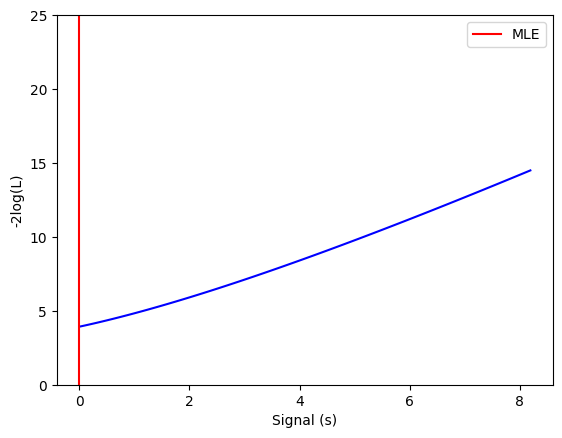

In [4]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.special import factorial

def log_like(x, b, N):
    s=x[0]
    if s<0:
        return np.inf
    
    else:
        mu = s+b
        
        #f(x) = P(X=x) = (e^(-λ)*(λ^x))/x!
        logl = N * np.log(mu) - mu - np.log(factorial(N))
        return -2*logl

  
b = 5      #background
N = 3     #Number of events

result = minimize(log_like, [1], args=(b, N), bounds=[(0, None)])
print(result)

s_values = np.linspace(0, N + 3*np.sqrt(N), 100)
neg_logL_values = [log_like([s], b, N) for s in s_values]

s_mle = result.x[0]

plt.plot(s_values, neg_logL_values, color='b')
plt.axvline(s_mle, color='r', label="MLE")
plt.xlabel("Signal (s)")
plt.ylabel("-2log(L)")
plt.ylim(0,25)
plt.legend()
plt.show()

In [3]:
print(s_mle)

94.99988820185246


## Discovery significance

You now wish to test $H_0$ against the alternative using the likelihood ratio: $\lambda = -2\times \mathrm{log}(\frac{\mathcal{L}(s)}{\mathcal{L}(\hat{s})})$

For this first test, set b=30. 
Generate N under $H_0$ to start with

Find the maximum likelihood and $\hat{s}$ by maximizing the likelihood (minimizing your function) and compute the log-likelihood ratio. 

Repeat the exercise 1000 times and store the best-fit signal and likelihood ratio for them 

Do the same with 1000 toy realisations where s=10

plot and compare distributions for s and $\lambda$

In [5]:
import scipy.stats as sps

In [9]:
def loglike2(x, b, N):
    s = x[0]
    if s<0:
        return np.inf
    else:
        mu = s + b
        logl2 = sps.poisson(mu).logpmf(N)
        #logl2 = N * np.log(mu) - mu - np.log(factorial(N)) 
        
        return -2*logl2

b = 30    
N = np.random.poisson(b)

result2 = minimize(loglike2, [1], args = (b, N), bounds=[(0,None)])

s_hat = result2.x[0]
lamda = loglike2([0], b, N) - result2.fun       # -2 * (likelihood at s=0 - likelihood MLE) and -2 already in loglike2

print("Value of s hat: ", s_hat)
print("Log-likelihood ratio: ", lamda)


Value of s hat:  5.999992199996682
Log-likelihood ratio:  1.127152089163019


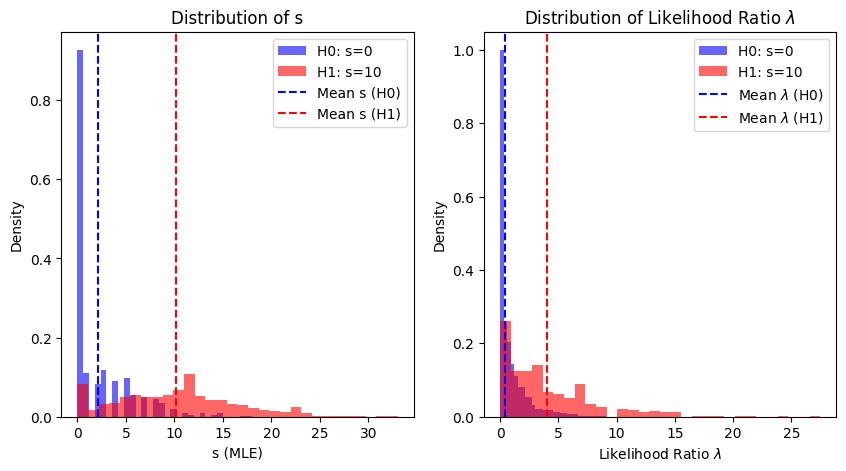

In [10]:
def MLE_and_lambda(b, N):
    result2 = minimize(loglike2, [1], args = (b, N), bounds=[(0,None)])    
    s_hat = result2.x[0]
    lamda = loglike2([0], b, N) - result2.fun   # logl_s0 - logl_sh   
    return s_hat, lamda


#Repeat the exercise 1000 times and store the best-fit signal and likelihood ratio for them

b = 30
n = 1000 #no of experiments
s_hats1 = []
lamdas1 = []

for i in range(n):
    N2 = np.random.poisson(b)
    s_hat1, lamda1 = MLE_and_lambda(b, N2)
    s_hats1.append(s_hat1)
    lamdas1.append(lamda1)
    

#Do the same with 1000 toy realisations where s=10

s2 = 10
s_hats2 = []
lamdas2 = []

for i in range(n):
    N3 = np.random.poisson(b + s2)
    s_hat2, lamda2 = MLE_and_lambda(b, N3)
    s_hats2.append(s_hat2)
    lamdas2.append(lamda2)




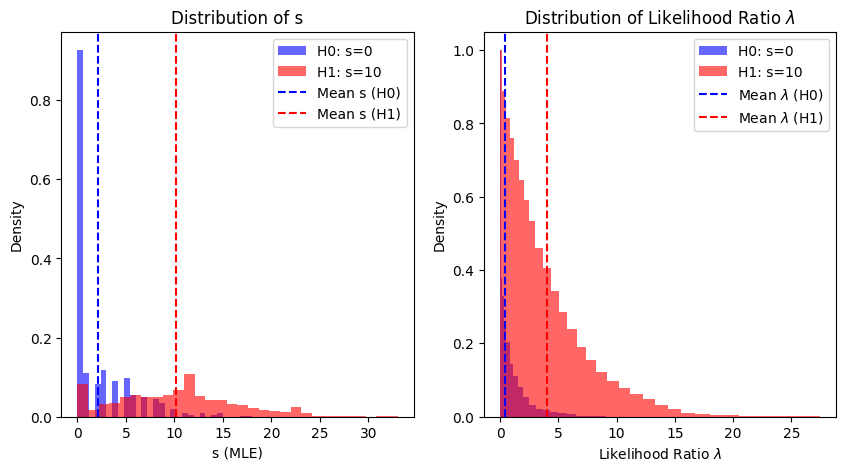

In [12]:
plt.figure(figsize=(10, 5))
    
plt.subplot(1, 2, 1)
plt.hist(s_hats1, bins=30, alpha=0.6, label='H0: s=0', color='blue', density=True)
plt.hist(s_hats2, bins=30, alpha=0.6, label='H1: s=10', color='red', density=True)
plt.axvline(np.mean(s_hats1), color='blue', linestyle='--', label='Mean s (H0)')
plt.axvline(np.mean(s_hats2), color='red', linestyle='--', label='Mean s (H1)')
plt.xlabel('s (MLE)')
plt.ylabel('Density')
plt.legend()
plt.title('Distribution of s')


plt.subplot(1, 2, 2)
plt.hist(lamdas1, bins=200, alpha=0.6, label='H0: s=0', color='blue', density=True, cumulative = -1)
plt.hist(lamdas2, bins=200, alpha=0.6, label='H1: s=10', color='red', density=True, cumulative = -1)
plt.axvline(np.mean(lamdas1), color='blue', linestyle='--', label=r'Mean $\lambda$ (H0)')
plt.axvline(np.mean(lamdas2), color='red', linestyle='--', label=r'Mean $\lambda$ (H1)')
plt.xlabel(r'Likelihood Ratio $\lambda$')
plt.ylabel('Density')
plt.legend()
plt.title('Distribution of Likelihood Ratio $\lambda$')

plt.show()

### With asymptotics

Since H0 is at a boundary, the asymptotic distribution of $\lambda$ should approach $0.5\cdot\chi^2(dof=1)$-- how does your result agree? Compute the distribution of p-values from $\lambda$ using this distribution under the null and alternative hypotheses-- do the p-value distributions look sensible?

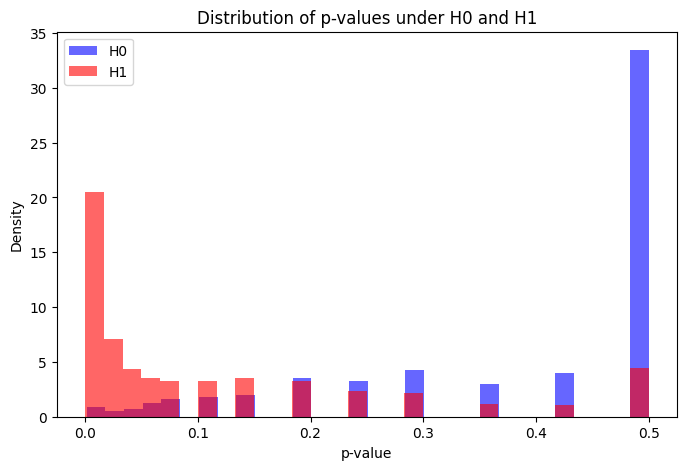

In [13]:
#CDF gives the probability of seeing a test statistic less than or equal to x
#but p-value is the probability of seeing a value greater than or equal to x

from scipy.stats import chi2

p_values_H0 = 0.5 - (0.5 * chi2.cdf(lamdas1, df=1))  
p_values_H1 = 0.5 - (0.5 * chi2.cdf(lamdas2, df=1))  

plt.figure(figsize=(8, 5))
plt.hist(p_values_H0, bins=30, alpha=0.6, label='H0', color='blue', density=True)
plt.hist(p_values_H1, bins=30, alpha=0.6, label='H1', color='red', density=True)
plt.xlabel('p-value')
plt.ylabel('Density')
plt.title('Distribution of p-values under H0 and H1')
plt.legend()
plt.show()

In [47]:
#p values are skewed towards 0, so we reject H0

###  Using toyMCs
now consider the case that b=2.5. Generate the same 1000 (or better, 10000 if you have time)  for H0 and H1: b=5
Plot the distributions-- do they agree with the asymptotic result? 
Using your samples of $\lambda$ generated under $H_0$, can you still assign the toy distributions under $H_1$ a p-value?  What is your power to exclude $H_0$ at, say, "3sigma"?

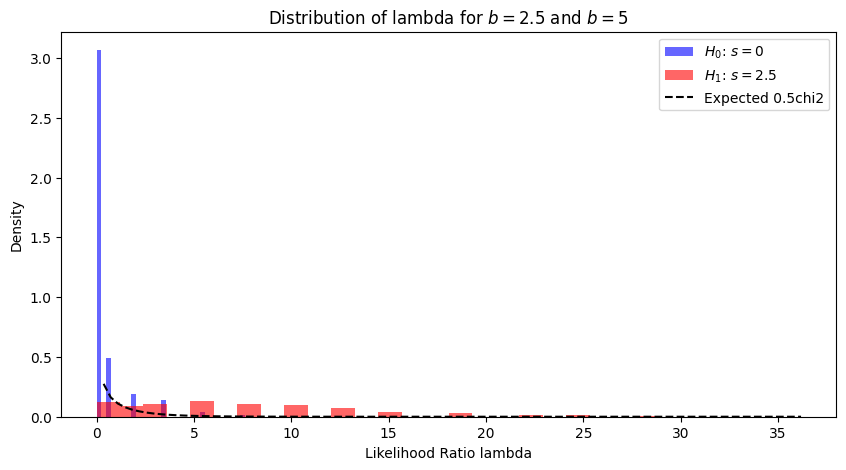

Power to exclude H0 at 3sigma:  0.327


In [15]:
b_h0 = 2.5
b_h1 = 2.5
num = 1000

s_hats_h0, lamdas_h0 = [], []
s_hats_h1, lamdas_h1 = [], []


#H0
for i in range(num):
    N_h0 = np.random.poisson(b_h0)
    s_hat, lamda = MLE_and_lambda(b_h0, N_h0)
    s_hats_h0.append(s_hat)
    lamdas_h0.append(lamda)

    
#H1
for i in range(num):
    N_h1 = np.random.poisson(b_h1 + 5)
    s_hat, lamda = MLE_and_lambda(b_h1, N_h1)
    s_hats_h1.append(s_hat)
    lamdas_h1.append(lamda)    

plt.figure(figsize=(10, 5))
plt.hist(lamdas_h0, bins=30, alpha=0.6, label=r'$H_0$: $s=0$', color='blue', density=True)
plt.hist(lamdas_h1, bins=30, alpha=0.6, label=r'$H_1$: $s=2.5$', color='red', density=True)


#compare with 0.5 * chi2 
x_vals = np.linspace(0, max(lamdas_h1), 100)

plt.plot(x_vals, 0.5 * chi2.pdf(x_vals, df=1), 'k--', label='Expected 0.5chi2')
plt.xlabel('Likelihood Ratio lambda')
plt.ylabel('Density')
plt.title('Distribution of lambda for $b=2.5$ and $b=5$')
plt.legend()
plt.show()


#p values
p_vals_H0 = 1 - (0.5 * chi2.cdf(lamdas_h0, df=1))
p_vals_H1 = 1 - (0.5 * chi2.cdf(lamdas_h1, df=1))


#3-sigma threshold: p ≈ 0.00135, so λ at 99.865 percentile
#Power

lambda_h0_3sigma = np.percentile(lamdas_h0, 99.865)  

count = 0 
for lambda_val in lamdas_h1:
    if lambda_val > lambda_h0_3sigma:
        count += 1

power_3sigma = count/num


#print("3-sigma threshold for lambda: ", lambda_3sigma)
print("Power to exclude H0 at 3sigma: ", power_3sigma)


In [71]:
#fails to reject H0 even when H1 is true. Most signals are not detected. Very low power at 3 sigma level

## With nuisance parameters


Now we'll make life more complicated, by allowing uncertainty about the expectation value of b

- Assume a statistical model where hat(b) is athe measurement of b, distributed like a gaussian with mean of b, and with a precision of 10%,
- write a -2 loglikelihood function that takes in x=[s,b] as well as fixed parameters hat(b), N
- Try minimizing this function, do the best-fit measurements make sense?
- In order to _profile_ this likelihood, you'll need a function where s is fixed, I suggest writing a small wrapper like: 

```def(x, sfix, bhat, N): ```<br>
```   return YourLogLikelihood([sfix, x[0], bhat, N)```

- Compute the constrained (with s fixed to some value) and free (minimizing both s, b) and find the profile log-likelihood ratio
- repeat the constrained fit for a range of values of s, and plot the profile likelihood and $\hat{\hat{b}}$ as functions of s
- generate some 1000 toyMCs and investigate the distribution of $\hat{s}$, $\hat{b}$ (the maximum likelihood estimators), as well as $\hat{\hat{b}}_s$-- the conditional/constrained best-fit b when you fix s. -- does it agree with your asymptotic expectations? 

###  With nuisance parameters near boundary
Try amending your likelihood to say that B cannot be smaller than some finite value, say 5, and compute the distribution of the test-statistic for s=0 and b=5, and compare with the asymptotic result. 

How far away from the boundary must b be before you reach an asymptotic distribution?